In [1]:
from roboflow import Roboflow
import os
from PIL import Image
import re

In [2]:
rf = Roboflow(api_key="ItoeXESUR3kCkABf6b9l")
project = rf.workspace().project("windows-instance-segmentation")
model = project.version(3).model

rf2 = Roboflow(api_key="JLpN0sT0VHsOJVVMYX40")
project2 = rf2.workspace().project("detecting-house")
model2 = project2.version(8).model

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


In [3]:
import pandas as pd

# add direction column to store the number of windows in that wall
school = pd.read_csv("School_ID_and_CORDS.csv")
school.head(2)
school['N'] = 0
school['E'] = 0
school['S'] = 0
school['W'] = 0
school['N_window_area'] = 0
school['E_window_area'] = 0
school['S_window_area'] = 0
school['W_window_area'] = 0
school['NE'] = 0
school['SE'] = 0
school['SW'] = 0
school['NW'] = 0
school['NE_window_area'] = 0
school['SE_window_area'] = 0
school['SW_window_area'] = 0
school['NW_window_area'] = 0

school['N_house_area'] = 0
school['E_house_area'] = 0
school['S_house_area'] = 0
school['W_house_area'] = 0
school['NE_house_area'] = 0
school['SE_house_area'] = 0
school['SW_house_area'] = 0
school['NW_house_area'] = 0

school['N_ratio'] = 0
school['E_ratio'] = 0
school['S_ratio'] = 0
school['W_ratio'] = 0
school['NE_ratio'] = 0
school['SE_ratio'] = 0
school['SW_ratio'] = 0
school['NW_ratio'] = 0

In [4]:
school.head(2)

,SchoolName,NCESID,Lat,Long,N,E,S,W,N_window_area,E_window_area,...,SW_house_area,NW_house_area,N_ratio,E_ratio,S_ratio,W_ratio,NE_ratio,SE_ratio,SW_ratio,NW_ratio
0,Another Course To College,250279000698,42.265168,-71.117736,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baldwin Early Learning Center,250279000011,42.342017,-71.140534,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
school.shape

(127, 36)

In [6]:
folder_path = "./dataset"

# Pre-clear the dataset file
# transfer the jpg and png into jepg
# clear all predict image at first

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        filepath = os.path.join(folder_path, filename)
        #print(filepath)
        with Image.open(filepath) as img:
            print(f"{filename}: {img.size}")
            rgb_img = img.convert("RGB")
            rgb_img.save(folder_path + "/" + filename[:-3] + "jpeg", "JPEG")
            os.remove(filepath)
    if filename[-12:-5]=="predict":
        os.remove(os.path.join(folder_path, filename))

In [7]:
# doing the window segmentation and generate the predict image
# for example: AbcSchool_NW.jpeg ---> AbcSchool_NW_redict_jpeg
import time
import re
pattern = r"[^a-zA-Z0-9]"

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        filepath = os.path.join(folder_path, filename)
        with Image.open(filepath) as img:
            try_time=1
            for i in range(0,3): # try 3 times at most
                try:
                    a = model.predict(filepath)
                    a_json = a.json()['predictions']
                    a.save(filepath[:-5]+"_predict.jpeg")
                    
                    b = model2.predict(filepath, confidence=5, overlap=5)
                    b_json = b.json()['predictions']
                    window_area = 0
                    for window_item in a_json:
                        window_area += window_item['width']*window_item['height']
                        
                    building_area = 0
                    window_area2 = 0
                    for building_item in b_json:
                        if building_item['class']=="house":
                            building_area += building_item['width']*building_item['height']*1.0
                        if building_item['class']=="window":
                            window_area2 += building_item['width']*building_item['height']*1.0
                        
                    avg_window_area = (window_area+window_area2)/2
                    ratio = 0
                    if building_area == 0:
                        ratio = 0
                        print("House building not recognized!")
                    else:
                        ratio = avg_window_area/building_area
                    print(avg_window_area, building_area, ratio)
                    
                    number_window = len(a.predictions)
                    start_index = filepath.rfind("_") + 1 
                    end_index = filepath.rfind(".")
                    direction = filepath[start_index:end_index]
                    the_str = filename[:filename.rfind("_")]
                    the_str = re.sub(pattern, '', the_str)
                    
                    
                    row_index = -1
                    for index, row in school.iterrows():
                        alpha_name = re.sub(pattern, '', row['SchoolName'])
                        if alpha_name in the_str:
                            #print(alpha_name, " ", the_str)
                            row_index = index
                            break
                    if row_index==-1:
                        raise ValueError("Something went wrong!")
                        
                    # window number
                    school.loc[row_index, direction] = number_window
                    # window area
                    school.loc[row_index, direction+"_window_area"] = avg_window_area
                    # house area
                    school.loc[row_index, direction+"_house_area"] = building_area
                    # ratio
                    school.loc[row_index, direction+"_ratio"] = ratio
                    
                    print(filename + " window/building segmentation completed.")
                    time.sleep(1)
                    break
                except:
                    if try_time<3:
                        print(filename + " window/building segmentation FAILED at round:", try_time, ". Do it again.")
                        try_time += 1
                        continue
                    else:
                        print(filename + " window/building segmentation FAILED at last.")
                        break
    
                        

14395.0 74224.0 0.19393996550980816
BostonLatin_E.jpeg window/building segmentation completed.
8514.5 70400.0 0.12094460227272727
LyonUpper912_N.jpeg window/building segmentation completed.
9663.0 13629.0 0.7090028615452344
SamuelWMason_NE.jpeg window/building segmentation completed.
6985.0 43677.0 0.15992398745335074
NewMissionHighSchool_E.jpeg window/building segmentation completed.
22839.5 74385.0 0.3070444310008738
EastBostonHigh_S.jpeg window/building segmentation completed.
417832.0 1354608.0 0.30845233454992144
HarvardKent_E.jpeg window/building segmentation completed.
21848.5 156000.0 0.14005448717948718
PatrickJKennedy_SE.jpeg window/building segmentation completed.
166707.5 1810733.0 0.09206630684921521
GreaterEglestonCommunityHighSchool_NE.jpeg window/building segmentation completed.
42208.5 120500.0 0.35027800829875516
JohnFKennedy_N.jpeg window/building segmentation completed.
MattahuntElementarySchool_NW.jpeg window/building segmentation FAILED at round: 1 . Do it again.


52108.5 258077.0 0.20191067007133529
JosephJHurley_NE.jpeg window/building segmentation completed.
26000.0 450378.0 0.05772928517822807
CurtisGuild_N.jpeg window/building segmentation completed.
26370.5 155480.0 0.16960702341137124
EliotElementary_N.jpeg window/building segmentation completed.
74880.0 250635.0 0.298761146687414
DonaldMckay_NW.jpeg window/building segmentation completed.
4221.0 21264.0 0.19850451467268623
OWHolmes_W.jpeg window/building segmentation completed.
25203.0 96196.0 0.26199634080419143
CurleyK8School_N.jpeg window/building segmentation completed.
44437.0 197664.0 0.22481079002752144
GardnerPilotAcademy_W.jpeg window/building segmentation completed.
33339.5 205409.0 0.16230788329625284
DrWilliamHendersonLower_E.jpeg window/building segmentation completed.
27362.0 164220.0 0.16661795152843747
LyonK8_S.jpeg window/building segmentation completed.
11365.5 69930.0 0.16252681252681253
LillaGFrederickMiddleSchool_SE.jpeg window/building segmentation completed.
50218.

226722.5 329868.0 0.6873128039094426
JohnWMccormack_E.jpeg window/building segmentation completed.
13993.0 120048.0 0.11656170864987338
CharlesSumner_NE.jpeg window/building segmentation completed.
32882.5 307180.0 0.10704635718471255
CondonK8_NE.jpeg window/building segmentation completed.
2625.5 48685.0 0.05392831467597823
GeorgeHConley_S.jpeg window/building segmentation completed.
48979.0 136444.0 0.3589677816540119
ExcelHighSchool_E.jpeg window/building segmentation completed.
19764.0 96612.0 0.20457086076263817
ThomasJKenny_N.jpeg window/building segmentation completed.
22522.0 42018.0 0.536008377362083
KingK8_S.jpeg window/building segmentation completed.
84083.5 436800.0 0.1924988553113553
OliverHazardPerry_S.jpeg window/building segmentation completed.
13069.5 375925.0 0.03476624326660903
MargaritaMunizAcademy_S.jpeg window/building segmentation completed.
22284.5 215180.0 0.10356213402732596
FranklinDRoosevelt_W.jpeg window/building segmentation completed.
57576.5 268034.0 0.

In [8]:
school.head(2)

,SchoolName,NCESID,Lat,Long,N,E,S,W,N_window_area,E_window_area,...,SW_house_area,NW_house_area,N_ratio,E_ratio,S_ratio,W_ratio,NE_ratio,SE_ratio,SW_ratio,NW_ratio
0,Another Course To College,250279000698,42.265168,-71.117736,5,0,2,9,21476.0,0.0,...,0.0,0.0,0.563971,0.0,0.07954,0.339802,0.000000,0.000000,0.0,0.000000
1,Baldwin Early Learning Center,250279000011,42.342017,-71.140534,0,0,0,0,0.0,0.0,...,0.0,198134.0,0.000000,0.0,0.00000,0.000000,0.087894,0.102526,0.0,0.112497


In [9]:
#school.to_csv('school_df.csv', index=False)

In [12]:
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 36 columns):
SchoolName        127 non-null object
NCESID            127 non-null int64
Lat               127 non-null float64
Long              127 non-null float64
N                 127 non-null int64
E                 127 non-null int64
S                 127 non-null int64
W                 127 non-null int64
N_window_area     127 non-null float64
E_window_area     127 non-null float64
S_window_area     127 non-null float64
W_window_area     127 non-null float64
NE                127 non-null int64
SE                127 non-null int64
SW                127 non-null int64
NW                127 non-null int64
NE_window_area    127 non-null float64
SE_window_area    127 non-null float64
SW_window_area    127 non-null float64
NW_window_area    127 non-null float64
N_house_area      127 non-null float64
E_house_area      127 non-null float64
S_house_area      127 non-null float64
W_house_area     

In [11]:
school.describe()

,NCESID,Lat,Long,N,E,S,W,N_window_area,E_window_area,S_window_area,...,SW_house_area,NW_house_area,N_ratio,E_ratio,S_ratio,W_ratio,NE_ratio,SE_ratio,SW_ratio,NW_ratio
count,1.270000e+02,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,...,1.270000e+02,1.270000e+02,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,2.502676e+11,42.319726,-71.088241,2.952756,3.669291,6.314961,2.661417,11479.460630,15002.240157,14592.901575,...,3.250102e+04,3.604555e+04,0.060164,0.062256,0.072588,0.035033,0.034271,0.026579,0.033783,0.037070
std,5.166815e+07,0.035193,0.035952,7.089964,9.262533,12.475818,7.395001,35077.953821,52580.982637,34996.235926,...,1.161882e+05,1.551280e+05,0.139317,0.135370,0.130594,0.084251,0.096013,0.080167,0.094802,0.115900
min,2.500049e+11,42.243207,-71.162628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.502790e+11,42.293088,-71.113624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.502790e+11,42.318547,-71.081831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.502790e+11,42.344399,-71.063367,0.500000,3.000000,5.500000,0.000000,1567.250000,4216.250000,14880.000000,...,0.000000e+00,0.000000e+00,0.000000,0.049607,0.096373,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.502790e+11,42.391609,-71.004144,43.000000,65.000000,59.000000,50.000000,233969.500000,417832.000000,247630.500000,...,1.052940e+06,1.467960e+06,0.624571,0.687313,0.578008,0.465233,0.709003,0.425974,0.636768,0.754367


In [18]:
print(school.describe().loc['max',['N','E','S','W','NE','NW','SE','SW']])
print(school.describe().loc['mean',['N','E','S','W','NE','NW','SE','SW']])

N     43.0
E     65.0
S     59.0
W     50.0
NE    37.0
NW    52.0
SE    57.0
SW    43.0
Name: max, dtype: float64
N     2.952756
E     3.669291
S     6.314961
W     2.661417
NE    2.496063
NW    2.322835
SE    1.921260
SW    2.393701
Name: mean, dtype: float64


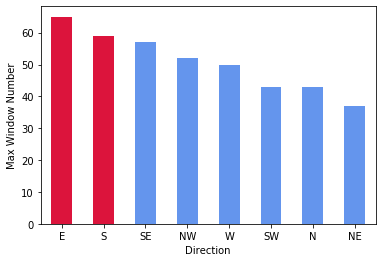

In [74]:
import matplotlib.pyplot as plt

grouped = school.describe().loc['max',['N','E','S','W','NE','NW','SE','SW']].sort_values(ascending=False)
colors = ['cornflowerblue'] * len(grouped)
colors[:2] = ['crimson'] * 2
grouped.plot(kind='bar', color=colors)
plt.xlabel('Direction')
plt.ylabel('Max Window Number')
plt.xticks(rotation=0)
plt.show()

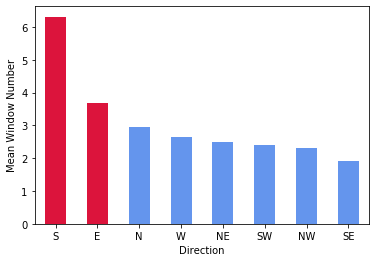

In [75]:
grouped = school.describe().loc['mean',['N','E','S','W','NE','NW','SE','SW']].sort_values(ascending=False)
colors = ['cornflowerblue'] * len(grouped)
colors[:2] = ['crimson'] * 2
grouped.plot(kind='bar', color=colors)
plt.xlabel('Direction')
plt.ylabel('Mean Window Number')
plt.xticks(rotation=0)
plt.show()

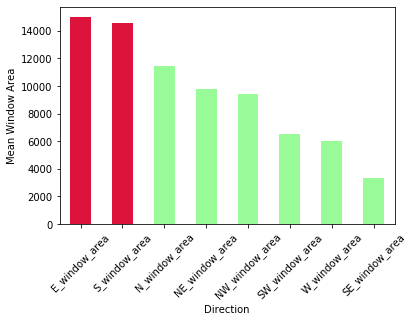

In [70]:
grouped = school.describe().loc['mean',['N_window_area','E_window_area','S_window_area','W_window_area','NE_window_area','NW_window_area','SE_window_area','SW_window_area']].sort_values(ascending=False)
colors = ['palegreen'] * len(grouped)
colors[:2] = ['crimson'] * 2
grouped.plot(kind='bar', color=colors)
plt.xlabel('Direction')
plt.ylabel('Mean Window Area')
plt.xticks(rotation=45)
plt.show()

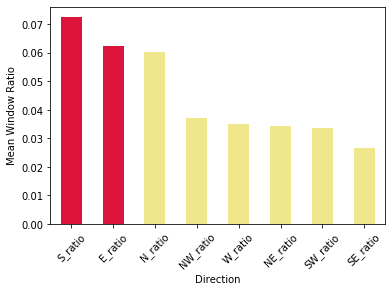

In [71]:
grouped = school.describe().loc['mean',['N_ratio','E_ratio','S_ratio','W_ratio','NE_ratio','NW_ratio','SE_ratio','SW_ratio']].sort_values(ascending=False)
colors = ['khaki'] * len(grouped)
colors[:2] = ['crimson'] * 2
grouped.plot(kind='bar', color=colors)
plt.xlabel('Direction')
plt.ylabel('Mean Window Ratio')
plt.xticks(rotation=45)
plt.show()

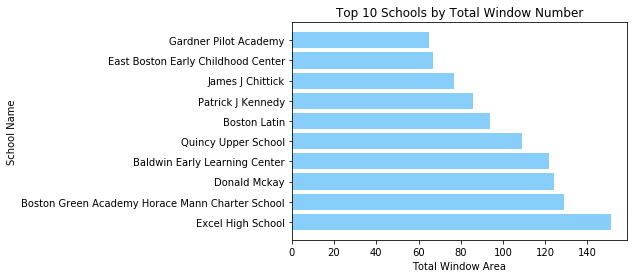

In [67]:
school['Total_window_number'] = school['N']+school['E']+school['S']+school['W']+school['NE']+school['NW']+school['SE']+school['SW']

sorted_df  = school.sort_values(by='Total_window_number', ascending=False)
top_ten = sorted_df.head(10)

plt.barh(top_ten['SchoolName'], top_ten['Total_window_number'], color='lightskyblue')
plt.title('Top 10 Schools by Total Window Number')
plt.xlabel('Total Window Area')
plt.ylabel('School Name')

# 显示图表
plt.show()

In [ ]:
# Take a glimpse about the predicted image.

import cv2
from matplotlib import pyplot as plt
index = 0
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        filepath = os.path.join(folder_path, filename)
        if "predict" not in filename:
            continue
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()
        index+=1 
    if index>1:
        break

In [ ]:
# show the counting number of the different directions in different schools.
school.head(5)

In [ ]:
# # infer on a local image
# print(model.predict("your_image.jpg").json())

# # infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE").json())

# # save an image annotated with your predictions
# model.predict("your_image.jpg").save("prediction.jpg")